
Training model for XOM...
Training R^2: 0.9922
Testing R^2: 0.9853
Training MSE: 0.0079
Testing MSE: 0.0143
Training MASE: 0.0609
Testing MASE: 0.0811


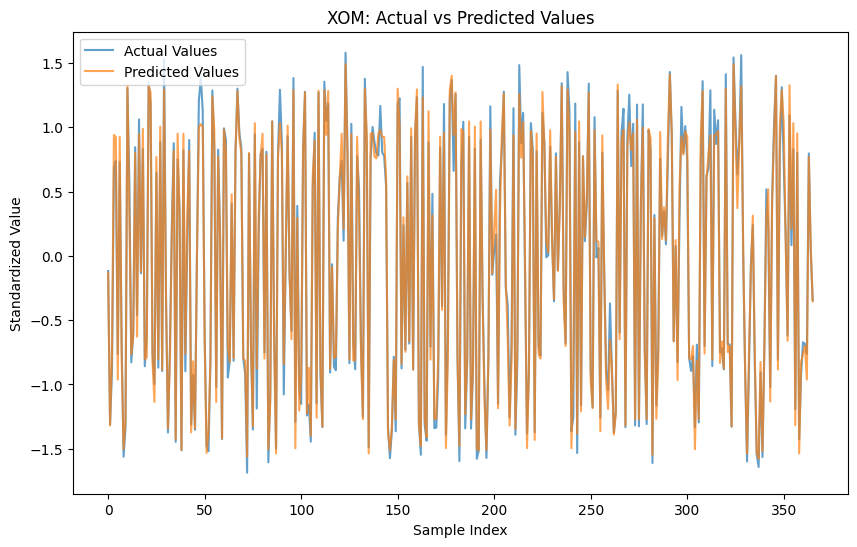

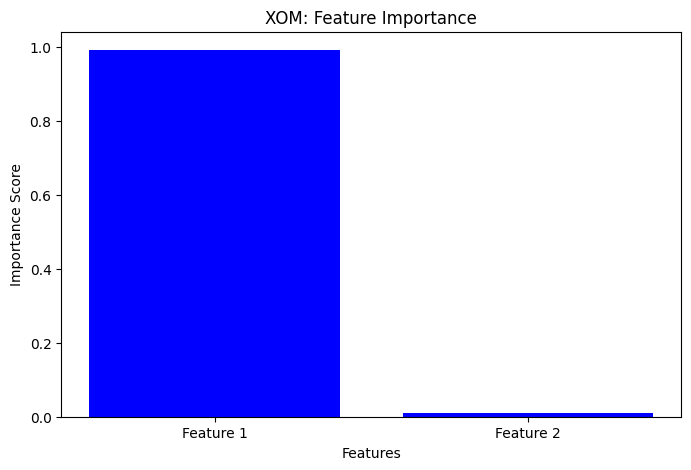


Training model for MSFT...
Training R^2: 0.9870
Testing R^2: 0.9801
Training MSE: 0.0131
Testing MSE: 0.0194
Training MASE: 0.0763
Testing MASE: 0.0939


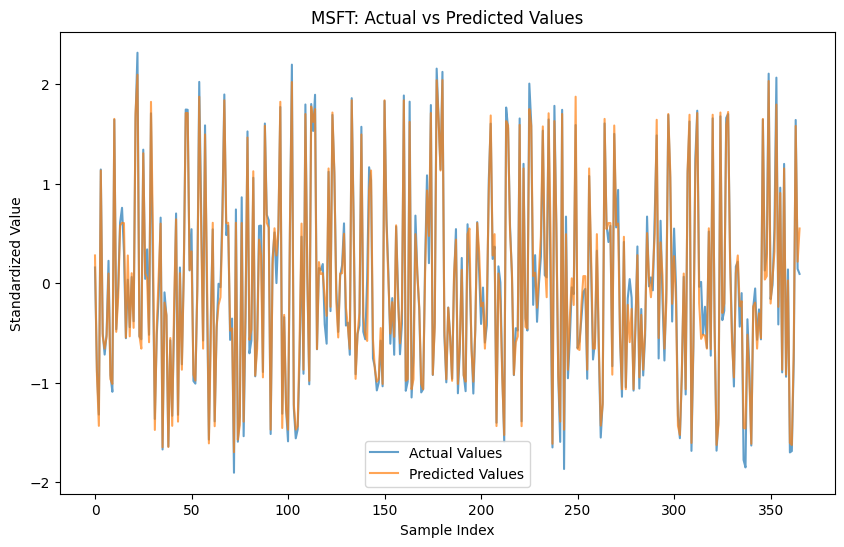

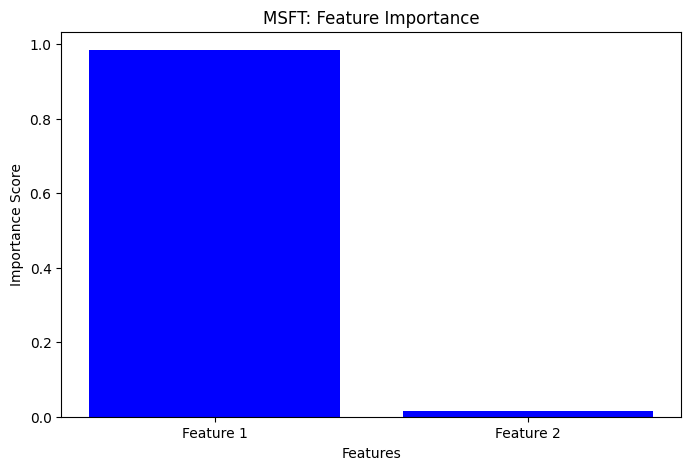


Training model for PFE...
Training R^2: 0.9658
Testing R^2: 0.9468
Training MSE: 0.0342
Testing MSE: 0.0533
Training MASE: 0.1195
Testing MASE: 0.1614


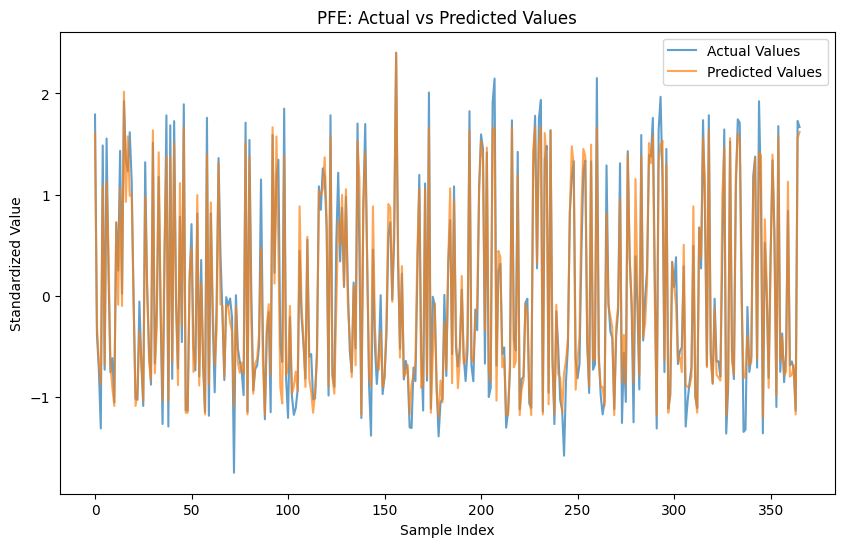

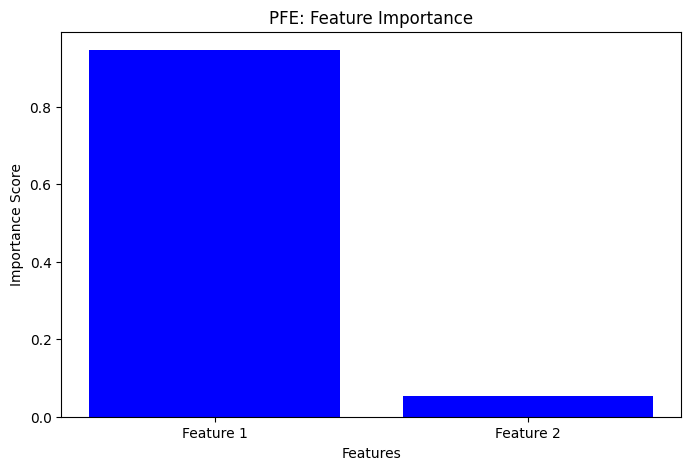


Optimal Portfolio Weights:
[('XOM', 0.0), ('MSFT', 1.0), ('PFE', 0.0)]

Optimal Portfolio Weights:
XOM: 0.00%
MSFT: 100.00%
PFE: 0.00%

Portfolio Total Return: 2.0997


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Feature Engineering Class
class FeatureEngineer:
    def __init__(self, window_size=40):
        self.scaler = StandardScaler()
        self.window_size = window_size

    def prepare_data(self, data, target_column):
        """
        Prepare features and target data.
        :param data: DataFrame containing stock data.
        :param target_column: Column name of the target stock.
        :return: Standardized features (X) and target (y).
        """
        # Compute rolling features
        data.loc[:, f'{target_column}_rolling_mean'] = data[target_column].rolling(window=self.window_size).mean()
        data.loc[:, f'{target_column}_rolling_std'] = data[target_column].rolling(window=self.window_size).std()

        # Drop NaN values caused by rolling operations
        data = data.dropna()

        # Define features and target
        feature_columns = [f'{target_column}_rolling_mean', f'{target_column}_rolling_std']
        X = data[feature_columns]
        y = data[target_column]

        # Standardize features and target
        X_scaled = self.scaler.fit_transform(X)
        y_scaled = self.scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

        return X_scaled, y_scaled

# Train and Evaluate Model for a Single Stock
def train_model(data, stock_name, window_size=40):
    print(f"\nTraining model for {stock_name}...")

    # Prepare data
    feature_engineer = FeatureEngineer(window_size=window_size)
    X_scaled, y_scaled = feature_engineer.prepare_data(data, target_column=stock_name)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

    # Initialize and train XGBoost model
    model = xgb.XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=4, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate model
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_score = r2_score(y_train, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mase = np.mean(np.abs(y_train - y_train_pred)) / np.mean(np.abs(np.diff(y_train)))
    test_mase = np.mean(np.abs(y_test - y_test_pred)) / np.mean(np.abs(np.diff(y_test)))

    print(f"Training R^2: {train_score:.4f}")
    print(f"Testing R^2: {test_score:.4f}")
    print(f"Training MSE: {train_mse:.4f}")
    print(f"Testing MSE: {test_mse:.4f}")
    print(f"Training MASE: {train_mase:.4f}")
    print(f"Testing MASE: {test_mase:.4f}")

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label="Actual Values", alpha=0.7)
    plt.plot(y_test_pred, label="Predicted Values", alpha=0.7)
    plt.legend()
    plt.title(f"{stock_name}: Actual vs Predicted Values")
    plt.xlabel("Sample Index")
    plt.ylabel("Standardized Value")
    plt.show()

    # Display feature importance
    importance = model.feature_importances_
    plt.figure(figsize=(8, 5))
    plt.bar([f"Feature {i+1}" for i in range(len(importance))], importance, color='blue')
    plt.title(f"{stock_name}: Feature Importance")
    plt.xlabel("Features")
    plt.ylabel("Importance Score")
    plt.show()

    return model

# Optimize Portfolio Weights
def optimize_weights(predictions, actual_returns):
    """
    Calculate weights to maximize returns.
    :param predictions: Predicted returns for each stock.
    :param actual_returns: Actual returns for each stock.
    :return: Optimal weights.
    """
    def objective(weights):
        portfolio_return = -np.dot(weights, actual_returns)  # Negative for maximization
        return portfolio_return

    # Constraints: Weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

    # Weight bounds: Each stock's weight is between [0, 1]
    bounds = [(0, 1) for _ in predictions]

    # Initial weights (equal distribution)
    initial_weights = [1 / len(predictions)] * len(predictions)

    # Minimize negative portfolio return
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)

    return result.x

# Calculate Portfolio Weights
def calculate_portfolio_weights(models, data):
    """
    Calculate optimal portfolio weights based on model predictions.
    :param models: Dictionary of trained models.
    :param data: DataFrame containing stock data.
    :return: Optimal weights and corresponding return.
    """
    predictions = {}
    for stock, model in models.items():
        feature_engineer = FeatureEngineer(window_size=40)
        X_scaled, _ = feature_engineer.prepare_data(data, target_column=stock)
        predictions[stock] = model.predict(X_scaled[-1].reshape(1, -1))[0]  # Predict latest return

    # Calculate actual returns
    actual_returns = data.iloc[-1][['XOM', 'MSFT', 'PFE']] / data.iloc[0][['XOM', 'MSFT', 'PFE']] - 1

    # Optimize weights
    optimal_weights = optimize_weights(list(predictions.values()), actual_returns.values)

    # Calculate portfolio return
    portfolio_return = np.dot(optimal_weights, actual_returns.values)

    return dict(zip(['XOM', 'MSFT', 'PFE'], optimal_weights)), portfolio_return

# Load Data
file_path = '/content/combined_stock_data.csv'
data = pd.read_csv(file_path)

# Filter "Adj Close" price data
filtered_data = data[['Date', 'Adj Close', 'Stock']]
filtered_data = filtered_data.pivot(index='Date', columns='Stock', values='Adj Close').reset_index()

# Convert stock prices to numeric types
filtered_data[['XOM', 'MSFT', 'PFE']] = filtered_data[['XOM', 'MSFT', 'PFE']].apply(pd.to_numeric, errors='coerce')
filtered_data = filtered_data.dropna()

# Train models for each stock
models = {}
for stock in ['XOM', 'MSFT', 'PFE']:
    models[stock] = train_model(filtered_data, stock_name=stock, window_size=40)

# Calculate optimal weights and returns
optimal_weights, portfolio_return = calculate_portfolio_weights(models, filtered_data)

# Print results
print("\nOptimal Portfolio Weights:")
print(list(optimal_weights.items()))
print("\nOptimal Portfolio Weights:")
for stock, weight in optimal_weights.items():
    print(f"{stock}: {weight:.2%}")
print(f"\nPortfolio Total Return: {portfolio_return:.4f}")
